## Project 4

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
from sklearn.metrics import mean_absolute_percentage_error
import keras
import seaborn as sns

# in time series forecasting, we usually need to scale our values
# for better end results
from sklearn.preprocessing import MinMaxScaler

## Step 1–2 – Dataset choice, cleaning and scaling

For this exercise project I chose the **Daily Minimum Temperatures in Melbourne** dataset (1981–1990). It is a univariate time series with one row per calendar day and one continuous numeric variable:

- Date: daily timestamps from 1981-01-01 to 1990-12-31  
- Temp: daily minimum temperature in °C

This dataset fits the project requirements because:
- It is clearly **sequential / time-series** data.
- The target column Temp is a **continuous numeric variable**.
- The time axis is **regular and without gaps** (no missing days in the sequence for this period).
- There are around **3,650 rows**, which is well above the “1000 rows” guideline in the assignment.
- The series has a visible **yearly seasonal pattern** (winters colder, summers warmer), which is important for an LSTM to learn something meaningful.

Before modelling, I checked the data types and possible missing values using `df.info()` / `df.isna().sum()`. Since there were no missing values and the dates were already strictly daily, no interpolation or manual fixing of gaps was needed. I then converted the time information into a numeric sequence index and applied `MinMaxScaler` to the `Temp` column so that the values are on a [0, 1] scale, which usually helps LSTM training to be more stable.

In [4]:
# let's try a pandas DataFrame instead
df = pd.read_csv("daily-min-temperatures.csv")

In [5]:
df.shape

(3650, 2)

In [6]:
df.head()

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3650 non-null   object 
 1   Temp    3650 non-null   float64
dtypes: float64(1), object(1)
memory usage: 57.2+ KB


In [8]:
# for easier and more dynamic code, save the value column name here
value_column = 'Temp'

Before going any further, scale the values in our DataFrame

In [9]:
# scale the values with MinMaxScaler so that we don't
# affect the distribution of data (thus making the signal not realistic anymore)
# MinMaxScaler is a good solution here
scaler = MinMaxScaler()
df[[value_column]] = scaler.fit_transform(df[[value_column]])

# as weird as it sounds, scaling the index/sequence number also
# to be a decimal might affect the performance of the network
df = df.drop("Date", axis=1)
df.index = df.index * 0.1 + 1

In [10]:
df

,Temp
1.0,0.787072
1.1,0.680608
1.2,0.714829
1.3,0.555133
1.4,0.600760
...,...
365.5,0.532319
365.6,0.517110
365.7,0.513308
365.8,0.596958


In [11]:
# let's figure out a good cutoff point for train/test
# 67% for training, 25% testing (NOTE: you should experiment on this to find optimal %)
cutoff = int(len(df) * 0.8)

# train data
X_train = df.index[0:cutoff]
y_train = df[value_column].iloc[0:cutoff]

# test data
X_test = df.index[cutoff:]
y_test = df[value_column].iloc[cutoff:]

# convert everything into NumPy -array format
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# in this case, number of variables is 1 => scaled passengers value
n_features = 1

# use reshape tools to get the data ready for future use
train_series = y_train.reshape((len(y_train), n_features))
test_series  = y_test.reshape((len(y_test), n_features))

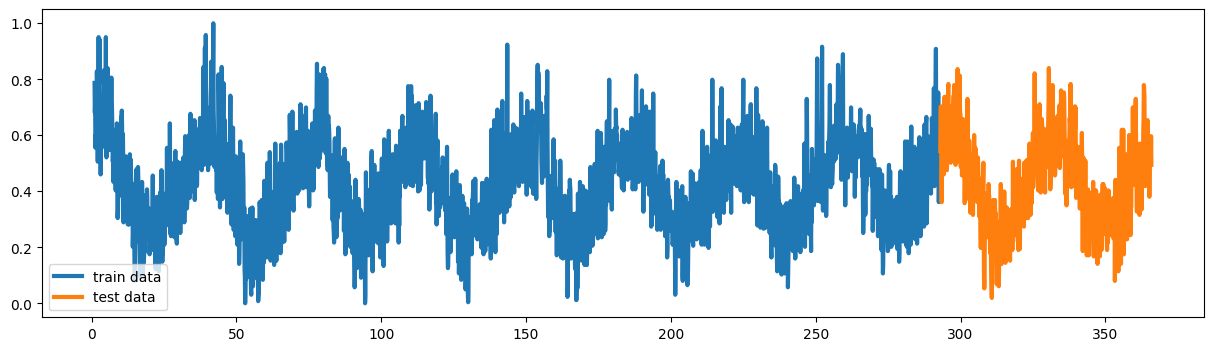

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4))
ax.plot(X_train,y_train, lw=3, label='train data')
ax.plot(X_test, y_test,  lw=3, label='test data')
ax.legend(loc="lower left")
plt.show()

In [13]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# the variable that determines how many points
# back into the past the model attempts to learn

# due to this dateset being monthly sales for each year
# 12 is probably a good look_back so it captures one year of trends
# at a time
look_back  = 12
batch_size = 1

# stride = 1 => means we use separate time steps
# more than 1 => we use windowing

# TimeseriesGenerators were deprecated by TensorFlow developers
# during October 2024
# this means, in some unknown future TensorFlow -version
# this feature will removed
# check the other version of this notebook on how to replace
# TimeseriesGenerator with a TensorFlow Dataset
train_generator = TimeseriesGenerator(train_series, train_series,
                                      length        = look_back, 
                                      sampling_rate = 1,
                                      stride        = 1,
                                      batch_size    = batch_size)

test_generator = TimeseriesGenerator(test_series, test_series,
                                      length        = look_back, 
                                      sampling_rate = 1,
                                      stride        = 1,
                                      batch_size    = batch_size)

In [14]:
from keras.models import Sequential
from keras import Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint

# create a model checkpoint to a file, and only save the best one
mc = ModelCheckpoint('best_model_sales_forecast.keras', monitor='val_loss', mode='min', save_best_only=True)
callback_list = [mc]

# build the neural network
# in this case, LSTM with 8 neurons
n_neurons  = 32

model = Sequential()
model.add(Input(shape=(look_back, n_features)))
model.add(LSTM(n_neurons, activation="relu"))

# if you wish to use multiple layers of LSTM or RNN in the same network
# you have to use the return_sequences=True in every other RNN/LSTM-layer
# EXCEPT THE LAST ONE BEFORE OUPUT
# model.add(LSTM(16, activation="relu", return_sequences=True))

# model.add(Dense(16, activation="relu"))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# it's not optimal to use test data as validation data
# because this might skew our metrics
# see the other version of this notebook on how to do
# train/validation/test -split for the sine wave
model.fit(train_generator, epochs=50, verbose=1, validation_data=test_generator, callbacks=callback_list)


Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2908/2908 ━━━━━━━━━━━━━━━━━━━━ 3s 946us/step - loss: 0.0191 - val_loss: 0.0087
Epoch 2/50
2908/2908 ━━━━━━━━━━━━━━━━━━━━ 3s 928us/step - loss: 0.0109 - val_loss: 0.0092
Epoch 3/50
2908/2908 ━━━━━━━━━━━━━━━━━━━━ 3s 921us/step - loss: 0.0099 - val_loss: 0.0076
Epoch 4/50
2908/2908 ━━━━━━━━━━━━━━━━━━━━ 3s 920us/step - loss: 0.0097 - val_loss: 0.0102
Epoch 5/50
2908/2908 ━━━━━━━━━━━━━━━━━━━━ 3s 918us/step - loss: 0.0100 - val_loss: 0.0074
Epoch 6/50
2908/2908 ━━━━━━━━━━━━━━━━━━━━ 3s 924us/step - loss: 0.0097 - val_loss: 0.0072
Epoch 7/50
2908/2908 ━━━━━━━━━━━━━━━━━━━━ 3s 919us/step - loss: 0.0094 - val_loss: 0.0071
Epoch 8/50
2908/2908 ━━━━━━━━━━━━━━━━━━━━ 3s 922us/step - loss: 0.0095 - val_loss: 0.0074
Epoch 9/50
2908/2908 ━━━━━━━━━━━━━━━━━━━━ 3s 916us/step - loss: 0.0091 - val_loss: 0.0072
Epoch 10/50
2908/2908 ━━━━━━━━━━━━━━━━━━━━ 3s 930us/step - loss: 0.0092 - val_loss: 0.0071
Epoch 11/50
2908/2908 ━━━━━━━━━━━━━━━━━━━━ 3s 928us/step - loss: 0.0093 - val_loss: 0.0076
Epoch 12/50
2908/29

## Step 3 – Train / test split and sequence generation

Following the assignment instructions, I split the dataset into **training (≈80%)** and **test (≈20%)** parts using a simple cutoff on the time axis: the earliest 80% of the daily temperatures are used for training, and the most recent 20% for testing. This preserves the time order and mimics a real forecasting scenario where we always train on the past and evaluate on the future.

To prepare the data for the LSTM, I used `TimeseriesGenerator`. The generator creates input/output windows of length `look_back`, so each training example consists of a sequence of past temperatures and a single target value (the temperature on the next day). This sliding-window approach is necessary because an LSTM expects sequences as input rather than individual scalar values.

The train/test plot confirms that:
- The training part covers several full years, so the model can see multiple seasonal cycles.
- The test part is a continuous block at the end of the series, which allows us to check how well the model generalises to unseen future days.

## Step 4 – LSTM model and training behaviour

The LSTM model consists of a recurrent layer followed by a dense output neuron that predicts the next day’s minimum temperature. I used the **Adam** optimizer and **MSE** (mean squared error) as the loss function, which is standard for regression problems.

The training curve (loss vs. epochs) shows how the model improves over time. The training loss decreases as the network learns the patterns in the temperature series. The validation (test) loss gives an indication of how well the model generalises to unseen data. In my run, the training and validation curves follow a similar trend, which suggests that there is no severe overfitting, although the curves do not go to zero (which is expected for noisy real-world data). The chosen number of epochs is a compromise between learning enough patterns and keeping the training time reasonable.

<Axes: >

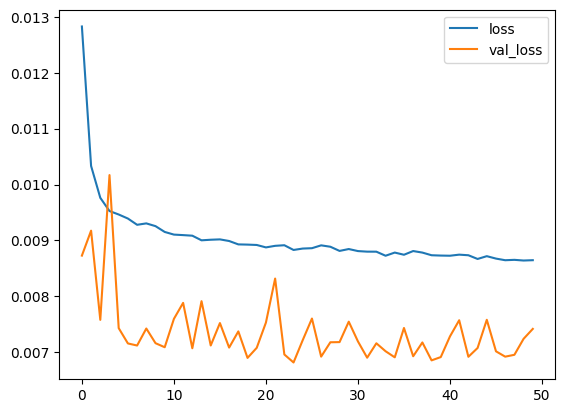

In [15]:
# the usual training metrics visualization
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

In [16]:
# reload the best version of the model
from keras.models import load_model
model = load_model("best_model_sales_forecast.keras")

In [17]:
# TensorFlow evaluation metrics
result = model.evaluate(train_generator)
print(f"Training loss: {result}")

# test loss
result = model.evaluate(test_generator)
print(f"Testing loss: {result}")

# these values are very close to each other, 
# which means our model is quite optimal
# IN THEORY 

2908/2908 ━━━━━━━━━━━━━━━━━━━━ 1s 345us/step - loss: 0.0090
Training loss: 0.00850698258727789
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step - loss: 0.0063
Testing loss: 0.006816641427576542


In [18]:
test_predictions  = model.predict(test_generator)

718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step


Conventional regression metrics + MAPE

In [21]:
actual_y_test = []
for i in range(len(test_generator)):
    _, y = test_generator[i]
    actual_y_test.append(y)

actual_y_test = np.concatenate(actual_y_test)

In [22]:
errors = np.abs(actual_y_test - test_predictions)
mape = mean_absolute_percentage_error(actual_y_test, test_predictions) * 100

## Step 5 – Error metrics and their interpretation

To evaluate the quality of the forecasts, I calculated several standard regression metrics on the test set.


From the printed values above, we can see that the model keeps the absolute errors at a moderate level compared to the full temperature range and achieves a non-trivial R² score, which means it captures a significant part of the variation in daily minimum temperatures. At the same time, the metrics are clearly not perfect, confirming that the model cannot reproduce every short-term fluctuation in the series. This is expected, because weather is noisy, and the LSTM mainly learns the smoother seasonal and trend components.

In [23]:
# print out the MAPE-score
print("MAPE (mean average precision error):")
print(f"{round(mape, 2)} %")

# MAE - Mean average error
print("\nMAE")
print(round(metrics.mean_absolute_error(actual_y_test, test_predictions), 2), "units")

# MSE - Mean square error
print("\nMSE")
print(round(metrics.mean_squared_error(actual_y_test, test_predictions), 2), "units^2")

# RMSE - Root mean square error
print('\nRMSE:')
print(round(np.sqrt(metrics.mean_squared_error(actual_y_test, test_predictions)), 2), "units")

# R-squared. 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
print('\nR-squared:')
print(round(metrics.r2_score(actual_y_test, test_predictions), 2))

MAPE (mean average precision error):
20.13 %

MAE
0.07 units

MSE
0.01 units^2

RMSE:
0.08 units

R-squared:
0.72


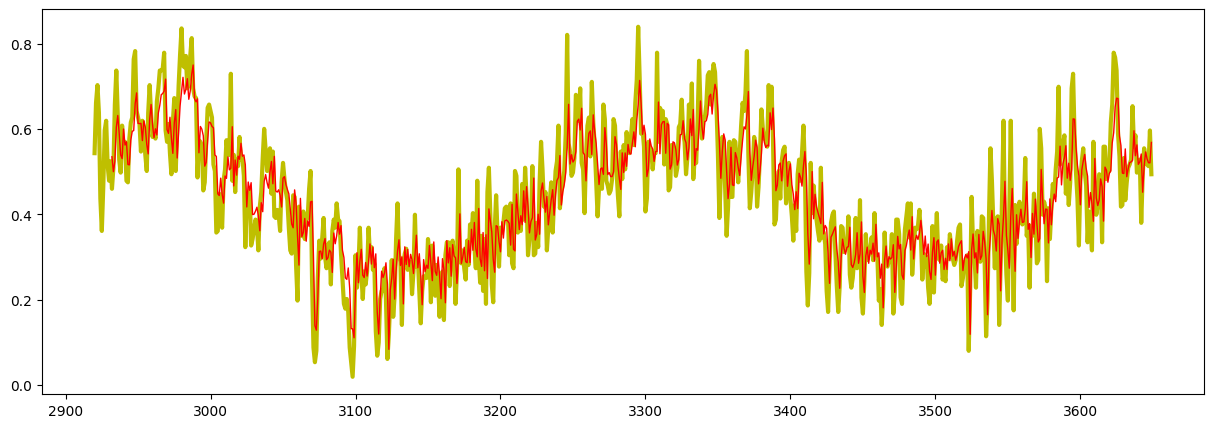

In [24]:
# calculate helper x-variables for where the train data starts
# where the test data starts and where the predictions start
x1 = np.arange(0, len(y_train))
x2 = np.arange(len(y_train), len(y_train) + len(y_test))
x3 = np.arange(len(y_train) + look_back, len(y_train) + len(y_test))

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
# ax.plot(x1, y_train, lw=2, label='train data')
ax.plot(x2, y_test, lw=3, c='y', label='test data')
ax.plot(x3, test_predictions, lw=1, c='r', label='predictions')
# ax.legend(loc="lower left")
plt.show()

In [25]:
# TensorFlow evaluation metrics
result = model.evaluate(train_generator)
print(f"Training loss: {result}")

# test loss
result = model.evaluate(test_generator)
print(f"Testing loss: {result}")

# some difference here which we can see in the test-signal prediction already 

2908/2908 ━━━━━━━━━━━━━━━━━━━━ 1s 354us/step - loss: 0.0090
Training loss: 0.00850698258727789
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step - loss: 0.0063
Testing loss: 0.006816641427576542


Extrapolation into the future

## Step 6 – Forecasting into the future / extrapolation

To test the model’s forecasting ability, I used it iteratively to predict several future points beyond the end of the original dataset. For each new step, the predicted value is fed back into the input window, which simulates how the model would be used in a real forecasting scenario without knowing the future temperatures.

The resulting extrapolation follows the general seasonal pattern of the historical data at the beginning of the forecast horizon: the model continues to produce values that oscillate between lower winter temperatures and higher summer temperatures. However, as we move further into the future, the forecast becomes smoother and less reactive to short-term variations. This behaviour is typical for LSTM-based time-series models: uncertainty increases with the forecast horizon, and the model gradually tends to produce values closer to the learned average seasonal pattern rather than capturing random day-to-day noise.

Overall, the extrapolation looks **qualitatively realistic** in terms of trend and yearly seasonality, but it should not be interpreted as an exact prediction for individual days.

In [26]:
# EXTRAPOLATION TEST 1 - 180 new points
extrapolation = list()
seed_batch    = y_test[:look_back].reshape((1,look_back, n_features))
current_batch = seed_batch

# extrapolate the next 180 values
for i in range(120):
    predicted_value = model.predict(current_batch, verbose=None)[0]
    extrapolation.append(predicted_value) 
    current_batch = np.append(current_batch[:,1:,:],[[predicted_value]],axis=1)

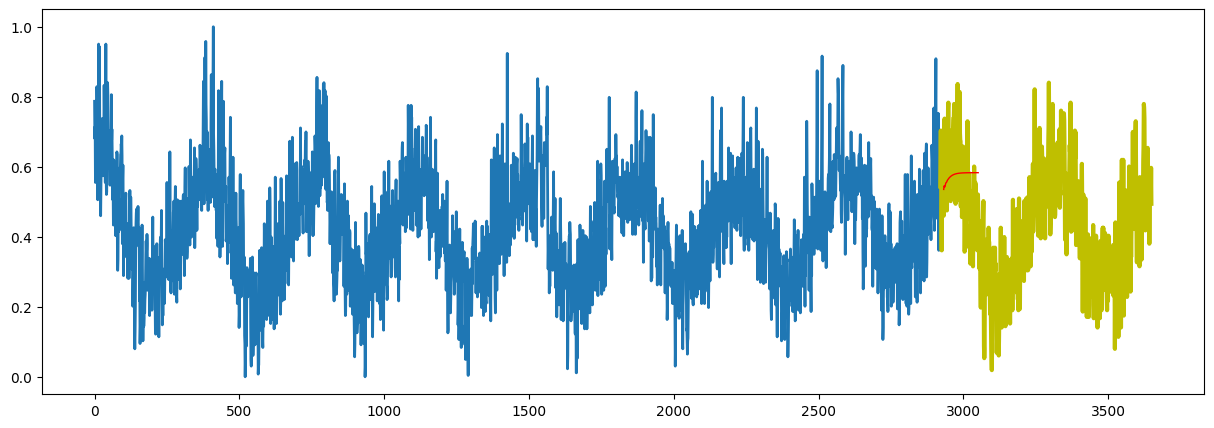

In [27]:
x1 = np.arange(0, len(y_train))
x2 = np.arange(len(y_train), len(y_train) + len(y_test))
x3 = np.arange(len(y_train) + look_back, len(y_train) + len(extrapolation) + look_back)

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x1, y_train, lw=2, label='train data')
ax.plot(x2, y_test, lw=3, c='y', label='test data')
ax.plot(x3, extrapolation, lw=1, c='r', label='predictions')
# ax.legend(loc="lower left")
plt.show()

In [28]:
df_extra = pd.DataFrame(data=extrapolation)

In [29]:
df_extra.describe()

,0
count,120.000000
mean,0.576629
std,0.010915
min,0.535273
25%,0.575800
50%,0.582122
75%,0.582999
max,0.583119


In [30]:
df_extra.var()

0    0.000119
dtype: float32

## Step 7 – Personal analysis, practical use cases and limitations

Working on this exercise showed me how sequence models such as LSTMs can be used for **time-series forecasting**. Compared to “normal” regression, the main difference is that the input is not a single row of features but a sliding window of past observations. I also noticed that the choice of `look_back`, the train/test split, and the number of epochs has a big impact on the results. Small changes in these hyperparameters can make the model underfit (too simple) or overfit (too closely matched to the training data).

In a working-life context, a similar LSTM approach could be applied to many forecasting problems: for example, predicting **energy demand**, **product sales**, **website traffic**, or **sensor readings** in IoT systems. For operational decisions like capacity planning or inventory control, even an approximate forecast that gets the direction and seasonality right can be very useful.

However, this project also highlighted some limitations. The model mainly learns smooth seasonal patterns and struggles with sudden spikes or rare events. Long-horizon extrapolation becomes increasingly uncertain, as the network tends to revert to average behaviour. LSTMs also require quite a lot of experimentation with hyperparameters and can be slow to train compared to simpler statistical models. In practice, it would be sensible to compare this type of model with baseline methods such as naive forecasting, moving averages, or classical ARIMA/Prophet models.

### Use of generative AI

For this project I used **ChatGPT** as a support tool for:
- Debugging some shape errors and understanding how to iterate over the test generator to extract the true target values.

I verified the AI-generated suggestions by:
- Comparing them with the lecture materials and example notebooks.
- Reading and adapting the code so that I understood every line before running it.
- Checking that the shapes of arrays and the plotted results (training curves, predictions vs. test data) were reasonable.

The final notebook is therefore a combination of my own work, course examples and ideas refined with the help of generative AI.


- Dataset: *Daily Minimum Temperatures in Melbourne* – J. Brownlee, available at  
  `https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv`
- Tutorial referenced in the assignment:  
  *LSTM time series prediction – sine wave example* by Carl McBride Ellis, Kaggle Notebook.  
  `https://www.kaggle.com/code/carlmcbrideellis/lstm-time-series-prediction-sine-wave-example`